# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

* https://github.com/pai4451/ML2021/tree/main/hw1

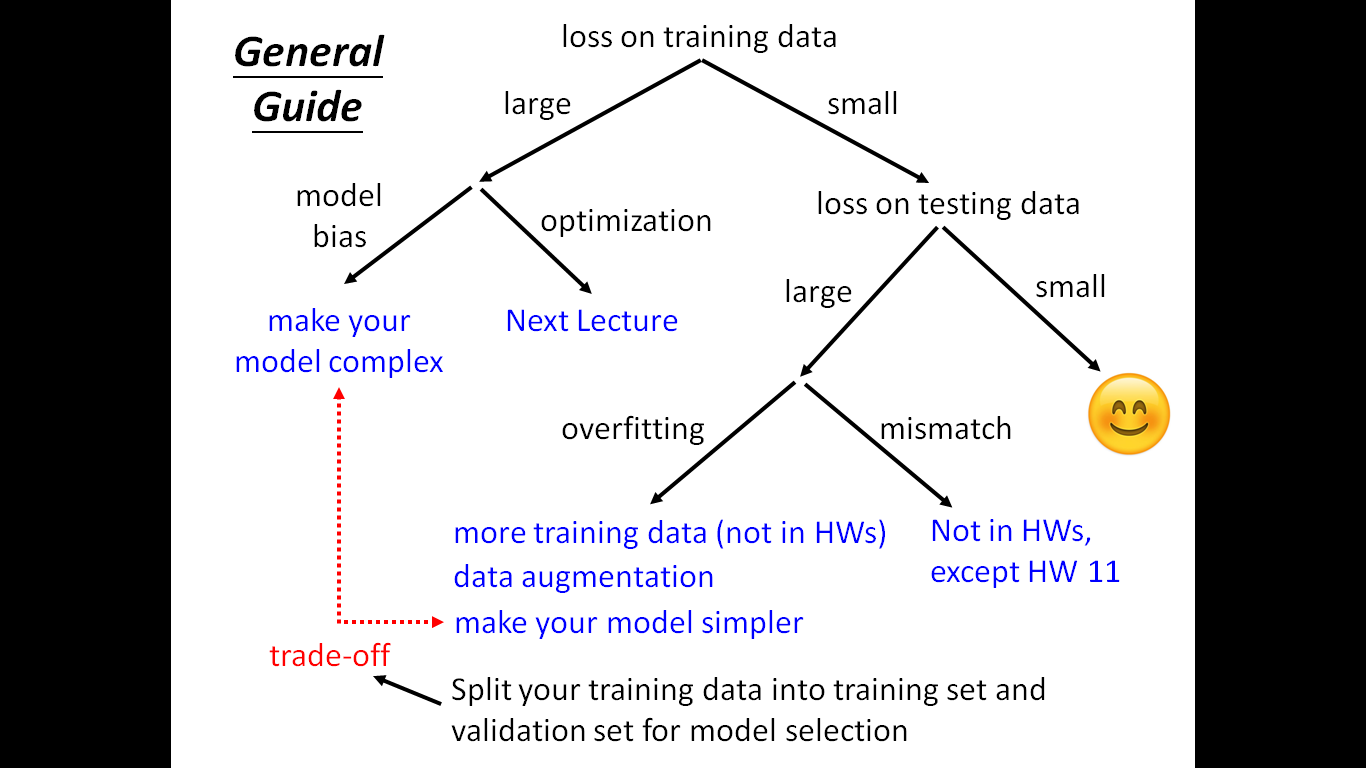

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/t/a3ebd5b5542f0f55e828d4f00de8e59a), and upload data manually to the workspace.

In [ ]:
# colab
# !gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
# !gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv
# train_path = "covid.train.csv"
# test_path = "covid.test.csv"

# kaggle
train_path = "../input/ml2022spring-hw1/covid.train.csv"
test_path = "../input/ml2022spring-hw1/covid.test.csv"

# Import packages

In [ ]:
# Numerical Operations
import math
import numpy as np

import matplotlib.pyplot as plt

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm.auto import tqdm

# Pytorch
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Data Info

In [ ]:
df = pd.read_csv(train_path)
df

In [ ]:
df.info()

In [ ]:
df.describe()

# Some Utility Functions

You do not need to modify this part.

In [ ]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# Dataset

In [ ]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [ ]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        def block(input, output):
            return nn.Sequential(
                nn.Linear(input, output),
                nn.BatchNorm1d(output),
                nn.ReLU(),
            )
            
        self.layers = nn.Sequential(
            block(input_dim, 64),
            block(64, 32),
            block(32, 16),
            block(16, 8),
            block(8, 4),
            block(4, 2),
            nn.Linear(2, 1),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.
* https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
* https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
* https://ithelp.ithome.com.tw/articles/10245037

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest
from matplotlib import pyplot

def select_k_feat(train_data, select_k):   
    y_train = train_data.iloc[:,-1]
    x_train = train_data.iloc[:,:-1]

    selection = SelectKBest(mutual_info_regression, k=select_k).fit(x_train, y_train)

    # what are scores for the features
    # for i in range(len(selection.scores_)):
    #     print('Feature %d: %f' % (i, selection.scores_[i]))
    # plot the scores,
    pyplot.figure(figsize=(20, 8), dpi=80)
    pyplot.bar([i for i in range(len(selection.scores_))], selection.scores_, tick_label=x_train.columns)
    pyplot.tick_params(rotation=90)
    pyplot.show()

    print(x_train.columns[selection.get_support()])
    
    return selection.get_support()

# Training Loop

## Warmup

In [ ]:
import math

def get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
        The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
        The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
        The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
        The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
        following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
        The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    def lr_lambda(current_step, lowerbound=0.003):
        # Warmup
        if current_step < num_warmup_steps:
            return max(lowerbound, float(current_step) / float(max(1, num_warmup_steps)))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            lowerbound, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )
    

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

In [ ]:
def trainer(train_loader, valid_loader, model, config, device):
    train_loss = []
    valid_loss = []
    
    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
#     optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'] ,weight_decay=2e-5) 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
#     scheduler = get_cosine_schedule_with_warmup(optimizer, config['n_epochs']//10, config['n_epochs'])

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            
            # Huber's loss
            loss_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                loss_reg += F.huber_loss(torch.zeros_like(param), param, reduction='sum', delta=100.0)
            loss += 2e-5 * loss_reg
            
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        valid_loss.append(mean_valid_loss)
        print(f"Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}, lr: {optimizer.param_groups[0]['lr']:.6f}")
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('Model is not improving, so we halt the training session.')
            break
        
#         scheduler.step()
    
    print("=========================================================")
    print(f"best_loss: {best_loss}")
    return train_loss, valid_loss

In [ ]:
def loss_fn_dml(input, target):
    input = input.unsqueeze(1)
    target = target.unsqueeze(1)
    
    return F.huber_loss(target, input, reduction='mean', delta=1.0)
#     return F.kl_div(F.log_softmax(input, dim=1),
#                         F.softmax(target, dim=1),
#                         log_target=False,
#                         reduction='batchmean')

def trainer_dml(train_loader, valid_loader, model1, model2, config, device):
    train_loss = []
    valid_loss = []
    
    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
#     optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'] ,weight_decay=2e-5) 
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=config['learning_rate'], weight_decay=2e-5) 
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=config['learning_rate'], weight_decay=2e-5) 
#     optimizer1 = torch.optim.SGD(model1.parameters(), lr=config['learning_rate'], momentum=0.9) 
#     optimizer2 = torch.optim.SGD(model2.parameters(), lr=config['learning_rate'], momentum=0.9) 
#     scheduler = get_cosine_schedule_with_warmup(optimizer, config['n_epochs']//10, config['n_epochs'])

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model1.train() # Set your model to train mode.
        model2.train() # Set your model to train mode.
        loss_record1 = []
        loss_record2 = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)
        for x, y in train_pbar:                        
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            
            pred1 = model1(x)
            pred2 = model2(x)
            loss1 = criterion(pred1, y) + loss_fn_dml(pred1, pred2.detach())
            loss2 = criterion(pred2, y) + loss_fn_dml(pred2, pred1.detach())
            
#             # Huber's loss
#             loss_reg1 = torch.tensor(0.).to(device)
#             for param in model1.parameters():
#                 loss_reg1 += F.huber_loss(torch.zeros_like(param), param, reduction='sum', delta=100.0)
#             loss1 += 2e-5 * loss_reg1
#             loss_reg2 = torch.tensor(0.).to(device)
#             for param in model2.parameters():
#                 loss_reg2 += F.huber_loss(torch.zeros_like(param), param, reduction='sum', delta=100.0)
#             loss2 += 2e-5 * loss_reg2
            
            optimizer1.zero_grad()               # Set gradient to zero.
            loss1.backward()                     # Compute gradient(backpropagation).
            optimizer1.step()                    # Update parameters.
            optimizer2.zero_grad()               # Set gradient to zero.
            loss2.backward()                     # Compute gradient(backpropagation).
            optimizer2.step()                    # Update parameters.
            
            step += 1
            loss_record1.append(loss1.detach().item())
            loss_record2.append(loss2.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': f"{loss1.detach().item():.4f}|{loss2.detach().item():.4f}"})

        mean_train_loss1 = sum(loss_record1)/len(loss_record1)
        mean_train_loss2 = sum(loss_record2)/len(loss_record2)
        train_loss.append(min(mean_train_loss1, mean_train_loss2))
        writer.add_scalar('Loss1/train', mean_train_loss1, step)
        writer.add_scalar('Loss2/train', mean_train_loss2, step)

        model1.eval() # Set your model to evaluation mode.
        model2.eval() # Set your model to evaluation mode.
        loss_record1 = []
        loss_record2 = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred1 = model1(x)
                loss1 = criterion(pred1, y)
                pred2 = model2(x)
                loss2 = criterion(pred2, y)

            loss_record1.append(loss1.item())
            loss_record2.append(loss2.item())
            
        mean_valid_loss1 = sum(loss_record1)/len(loss_record1)
        mean_valid_loss2 = sum(loss_record2)/len(loss_record2)
        valid_loss.append(min(mean_valid_loss1, mean_valid_loss2))
        print(f"Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss1:.4f}|{mean_train_loss2:.4f}, Valid loss: {mean_valid_loss1:.4f}|{mean_valid_loss2:.4f}, lr: {optimizer1.param_groups[0]['lr']:.6f}|{optimizer2.param_groups[0]['lr']:.6f}")
        writer.add_scalar('Loss1/valid', mean_valid_loss1, step)
        writer.add_scalar('Loss2/valid', mean_valid_loss2, step)

        if min(mean_valid_loss1, mean_valid_loss2) < best_loss:
            best_loss = min(mean_valid_loss1, mean_valid_loss2)
            if mean_valid_loss1 <= mean_valid_loss2:
                torch.save(model1.state_dict(), config['save_path']) # Save your best model
            else:
                torch.save(model2.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('Model is not improving, so we halt the training session.')
            break
        
#         scheduler.step()
    
    print("=========================================================")
    print(f"best_loss: {best_loss}")
    return train_loss, valid_loss

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 3,      # Your seed number, you can pick your lucky number. :)
    'select_k': 20,   # select k features.
    'valid_ratio': 0.3,   # validation_size = train_size * valid_ratio, 0.2 is too small to represent the test data
    'n_epochs': 3000,     # Number of epochs.            
    'batch_size': 256,
    'learning_rate': 1e-1,
    'early_stop': 200,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [ ]:
import matplotlib.pyplot as plt

def show_plot(total, lr):
    optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, total//10, total)

    lrs = []

    for i in range(total):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(range(total), lrs)
    
    print(lrs[:5])
    print(lrs[-5:])
    
show_plot(config["n_epochs"], config["learning_rate"])

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [ ]:
# Set seed for reproducibility
same_seed(config['seed'])

# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv(train_path), pd.read_csv(test_path)

# Select fetures
features = select_k_feat(train_data, config['select_k'])
select_k_feat(train_data.loc[:, np.append(features, True)], "all")
train_data = train_data.loc[:, np.append(features, True)] # add y data
train_data = train_data.to_numpy()
test_data = test_data.loc[:, features]
test_data = test_data.to_numpy()
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"train_data size: {train_data.shape}")
print(f"valid_data size: {valid_data.shape}")
print(f"test_data size: {test_data.shape}")

# Data
y_train, y_valid = train_data[:,-1], valid_data[:,-1]
x_train, x_valid, x_test = train_data[:,:-1], valid_data[:,:-1], test_data

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

# Start training!

In [ ]:
%%script false --no-raise-error

model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
train_loss, valid_loss = trainer(train_loader, valid_loader, model, config, device)

In [ ]:
# %%script false --no-raise-error

model1 = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
model2 = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
train_loss, valid_loss = trainer_dml(train_loader, valid_loader, model1, model2, config, device)

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))

# Plot learning curves

## plot loss

In [ ]:
import matplotlib.pyplot as plt

title='deep model'
total_steps = len(train_loss)
x_1 = range(total_steps)
plt.figure(figsize=(20, 6))
plt.plot(x_1, train_loss, c='tab:red', label='train')
if len(valid_loss)!=0:
    x_2 = x_1[::len(train_loss) // len(valid_loss)]
    plt.plot(x_2, valid_loss, c='tab:cyan', label='dev')
plt.ylim(0.0, 5.)
plt.xlabel('Training steps')
plt.ylabel('MSE loss')
plt.title('Learning curve of {}'.format(title))
plt.legend()
plt.show()

## plot prediction

In [ ]:
model.eval()
preds, targets = [], []
for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = model(x)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()
targets = torch.cat(targets, dim=0).numpy()

lim = 35
plt.figure(figsize=(20, 6))
plt.scatter(targets, preds, c='r', alpha=0.5)
plt.plot([-0.2, lim], [-0.2, lim], c='b')
plt.xlim(-0.2, lim)
plt.ylim(-0.2, lim)
plt.xlabel('ground truth value')
plt.ylabel('predicted value')
plt.title('Ground Truth v.s. Prediction')
plt.show()

# Plot learning curves with `tensorboard` (optional)

`tensorboard` is a tool that allows you to visualize your training progress.

If this block does not display your learning curve, please wait for few minutes, and re-run this block. It might take some time to load your logging information. 

In [ ]:
%%script false --no-raise-error

%reload_ext tensorboard
%tensorboard --logdir=./runs/

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = predict(test_loader, model, device) 
save_pred(preds, 'pred.csv')         

# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)